In [1]:
%%capture
import operator

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from matplotlib import pyplot as plt
from tensorflow.keras import layers, utils, losses, models as mds, optimizers

if imp.util.find_spec('aggdraw'): import aggdraw
if imp.util.find_spec('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers
if imp.util.find_spec('tensorflow_models'): from official.vision.beta.ops import augment as visaugment
if imp.util.find_spec('tensorflow_probability'): from tensorflow_probability import distributions as tfd
if imp.util.find_spec('keras_tuner'): import keras_tuner as kt

## LSTM

In [3]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(20, 10)),
    layers.LSTM(20),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

2022-03-30 10:08:20.808747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/broxoli/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-30 10:08:20.809754: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 10:08:20.811286: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-19319V3): /proc/driver/nvidia/version does not exist
2022-03-30 10:08:20.857598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2480      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


# UNet

## Hyperparameters

In [ ]:
INITIAL_WIDTH = 64
DROPOUT_RATE = 0.6

## Attention Block

In [ ]:
def attention_block(x, g, dims, name='attention'):
    """
        x: Feature map from skip connection.
        g: Feature map from the last layer. It has smaller spatial dimensions
    """

    # Transform x with strided convolution to match gating dimensions
    stride_x = x.shape[1]//g.shape[1]
    # print('Initial Shapes: ', x.shape, g.shape, stride_x)
    x_transform = layers.Conv2D(dims, 3, (stride_x, stride_x), padding="same")(x)

    # Transform g with 1x1 convolution
    g_transform = layers.Conv2D(dims, 1, padding="same")(g)

    if DEBUG:
        print('x_transform: ', x_transform.shape, 'g_transform: ', g_transform.shape)

    # Combine transformed x and g and transform them to a single channel output
    # which will be used to scale the input x. A sigmoid function is applied
    # to the comination to ensure scaling factors in range [0,1)
    x_g_combined = layers.Add()([x_transform, g_transform])
    x_g_combined = layers.Activation('relu')(x_g_combined)

    if DEBUG:
        print('x_g_combined: ', x_g_combined.shape)
    # x_g_combined = layers.Activation('relu')(x_transform + g_transform)
    x_g_collapsed = layers.Conv2D(1, 1, padding='same', activation="relu")(x_g_combined)

    # Match the computed weights to the input x.
    attention_weights = layers.UpSampling2D((stride_x, stride_x))(x_g_collapsed)
    
    if DEBUG: print('attention_weights: ', attention_weights.shape)

    # Scale input x with attention
    attended_x = layers.Multiply()([attention_weights, x])

    if DEBUG: print('attended_x: ', attended_x.shape)

    # Apply another convolution to compute the output
    output = layers.Conv2D(x.shape[-1], 1, padding='same')(attended_x)
    output = layers.BatchNormalization()(output)

    block = tf.keras.Model(inputs=[x, g], outputs=output, name=name)

    # if DEBUG:
    #     print('attention_block: ', output.shape)
        
    return block([x, g])

# x = tf.random.normal((1, 32, 32, 64))
# g = tf.random.normal((1, 16, 16, 128))

# x = tf.keras.Input((32, 32, 64))
# g = tf.keras.Input((16, 16, 128))
# DEBUG = True
# attention_block(x, g, 32)

# for l in att.layers[2:]:
#     print(l)
#     tfmot.sparsity.keras.prune_low_magnitude(l)

## Encoder and Decoder Blocks

In [ ]:
def encoder_block(input, width_multiplier, name='block'):
    kwargs = dict(activation="relu", padding="same")
    block = tf.keras.Sequential([
        layers.Conv2D(INITIAL_WIDTH*width_multiplier, (3, 3), **kwargs),
        layers.Conv2D(INITIAL_WIDTH*width_multiplier, (3, 3), **kwargs),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(DROPOUT_RATE)
    ], name=name)

    # conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
    #                        (3, 3), activation="relu", padding="same")(input)
    # conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
    #                        (3, 3), activation="relu", padding="same")(conv_1)
    # normalization = layers.BatchNormalization()(conv_2)
    # pool = layers.MaxPooling2D((2, 2))(normalization)
    # dropout = layers.Dropout(DROPOUT_RATE)(pool)

    # if DEBUG:
    #     print(name, input.shape, conv_1.shape, conv_2.shape, pool.shape)

    return block(input)

def decoder_block(input, skip_input, width_multiplier, name='block'):
    kwargs = dict(activation="relu", padding="same")

    # Apply attention to the skip input
    attended_skip_input = attention_block(skip_input, input, INITIAL_WIDTH*width_multiplier, name='attention_{}'.format(name))

    conv_transpose = layers.Conv2DTranspose(
        INITIAL_WIDTH*width_multiplier, (3, 3), strides=(2, 2), padding='same')(input)

    crop_size = conv_transpose.shape[1]

    if DEBUG: print('crop_size: ', crop_size, 'attended_skip_input: ', attended_skip_input.shape)
    # cropped_skip_input = layers.CenterCrop(crop_size, crop_size)(attended_skip_input)
    # conv_input = layers.Concatenate()([conv_transpose, cropped_skip_input])
    conv_input = layers.Concatenate()([conv_transpose, attended_skip_input])

    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), **kwargs)(conv_input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), **kwargs)(conv_1)
    normalization = layers.BatchNormalization()(conv_2)
    
    dropout = layers.Dropout(DROPOUT_RATE)(normalization)

    block = tf.keras.Model(inputs=[input, attended_skip_input], outputs=dropout, name=name)

    # print(block.layers)

    # for l in block.layers[3:]:
    #     print(l)
    #     tfmot.sparsity.keras.prune_low_magnitude(l)

    # dropout = layers.Dropout(DROPOUT_RATE)(conv_2)

    # if DEBUG:
    #     print(name, conv_input.shape, conv_1.shape, conv_2.shape)

    return block([input, attended_skip_input])

# x = tf.keras.Input((32, 32, 64))
# g = tf.keras.Input((16, 16, 128))
# DEBUG = True
# decoder_block(g, x, 2)

## Training Parameters

In [ ]:
N_ENCODERS = 2
# LEARNING_RATE = 0.0003
LEARNING_RATE = 0.001
LR_DECAY_EPOCHS = 10
LR_DECAY_RATE = .5
STEPS_PER_EPOCH = 805
# MAX_BOXES = 500
PRUNING_WEIGHT_RESET_EPOCHS = 1
PRUNING_TRAINING_EPOCHS = 1
LOG_DIR = './sequence_of_bboxes'

## Loss, Metrics and Model Assembly

* The resize block reformats the UNet output as desired. 

In [ ]:
def resize_block(input):
    [y_input, x_input, h_input, w_input] = layers.Lambda(lambda x: tf.split(x, 4, axis=-1))(input)

    initial_channel_width = y_input.shape[1]
    kwargs = dict(padding='same')
    y_leg = tf.keras.Sequential([
        layers.Conv2D(initial_channel_width*2, 3, activation='relu', **kwargs),
        layers.MaxPool2D((1, initial_channel_width*2), strides=(1, initial_channel_width*2), **kwargs),
        layers.Conv2D(MAX_BOXES, 3, activation='sigmoid', **kwargs),
        layers.MaxPool2D((initial_channel_width*2, 1), strides=(initial_channel_width*2, 1), **kwargs),
        layers.Reshape([MAX_BOXES, -1]),
    ], name='y_leg')

    x_leg = tf.keras.Sequential([
        layers.Conv2D(initial_channel_width*2, 3, activation='relu', **kwargs),
        layers.MaxPool2D((initial_channel_width*2, 1), strides=(initial_channel_width*2, 1), **kwargs),
        layers.Conv2D(MAX_BOXES, 3, activation='sigmoid', **kwargs),
        layers.MaxPool2D((1, initial_channel_width*2), strides=(1, initial_channel_width*2), **kwargs),
        layers.Reshape([MAX_BOXES, -1]),
    ], name='x_leg')

    h_leg = tf.keras.Sequential([
        layers.Conv2D(initial_channel_width*2, 3, activation='relu', **kwargs),
        layers.AveragePooling2D((1, initial_channel_width*2), strides=(1, initial_channel_width*2), **kwargs),
        layers.Conv2D(MAX_BOXES, 3, activation='sigmoid', **kwargs),
        layers.AveragePooling2D((initial_channel_width*2, 1), strides=(initial_channel_width*2, 1), **kwargs),
        layers.Reshape([MAX_BOXES, -1]),
    ], name='h_leg')

    w_leg = tf.keras.Sequential([
        layers.Conv2D(initial_channel_width*2, 3, activation='relu', **kwargs),
        layers.AveragePooling2D((initial_channel_width*2, 1), strides=(initial_channel_width*2, 1), **kwargs),
        layers.Conv2D(MAX_BOXES, 3, activation='sigmoid', **kwargs),
        layers.AveragePooling2D((1, initial_channel_width*2), strides=(1, initial_channel_width*2), **kwargs),
        layers.Reshape([MAX_BOXES, -1]),
    ], name='w_leg')

    output = layers.Concatenate()([
        y_leg(y_input), 
        x_leg(x_input), 
        h_leg(h_input), 
        w_leg(w_input), 
    ])

    return output

def create_model():
    inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

    encoder_blocks = list(accumulate([inp] + list(range(1, N_ENCODERS+1)), lambda x,
                                     idx: encoder_block(x, idx, name='encoder_{}'.format(idx))))

    # Remove the initial input from the list of encoder blocks
    encoder_blocks.pop(0)

    # Create the mid block. It is kept separate from the encoder blocks
    # because it doesn't have a corresponding decoder block.
    mid_block = encoder_block(
        encoder_blocks[-1], N_ENCODERS+1, name='bottom_of_u')

    decoder_blocks = list(accumulate([mid_block] + list(enumerate(reversed(encoder_blocks))), lambda x, item: decoder_block(
        x, item[1], N_ENCODERS - item[0], 'decoder_{}'.format(item[0]+1))))

    # Remove the mid block from the list of decoder blocks
    decoder_blocks.pop(0)

    output = resize_block(decoder_blocks[-1])
    m = tf.keras.Model(inputs=inp, outputs=output)
    lr_schedule = optimizers.schedules.InverseTimeDecay(
        LEARNING_RATE,
        decay_steps=STEPS_PER_EPOCH*LR_DECAY_EPOCHS,
        decay_rate=LR_DECAY_RATE,
        staircase=False)
    optimizer = optimizers.Adam(lr_schedule)
    # loss = compute_hw_loss
    # loss = 'mae'
    # metrics = ['accuracy']
    loss = compute_yxhw_loss
    metrics = []
    m.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return m

lr_schedule = optimizers.schedules.InverseTimeDecay(
        LEARNING_RATE,
        decay_steps=41,
        decay_rate=LR_DECAY_RATE,
        staircase=False)
optimizer = optimizers.Adam(lr_schedule)

model = create_model()
model.compile(optimizer=optimizer, loss=compute_yxhw_loss)
model.summary()

utils.plot_model(model, show_shapes=True, expand_nested=True)

# ViT

## Multilayer Perceptron

In [22]:
def mlp_block(xx, dims, dropout_rate, name='mlp_block'):
    block = tf.keras.Sequential([
        layers.Dense(dims*4, activation='gelu'),
        layers.Dense(dims),
        layers.Dropout(dropout_rate)
    ], name=name)

    return block(xx)

dims, dropout_rate = 8, .2
xx = tf.random.normal((2, 4, 4, 3))
output = mlp_block(xx, dims, dropout_rate)

print('Multilayer Perceptron')
print('dims: {} dropout_rate: {}'.format(dims, dropout_rate))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Multilayer Perceptron
dims: 8 dropout_rate: 0.2
Input: (2, 4, 4, 3) --> (2, 4, 4, 8)


## Embedding Block

In [23]:
def patch_embedding_block(xx, dims, name='patch_embedding_block'):
    """
        It embeds the input patches in dims-dimensional space.

        Arguments:
            xx: A tensor with shape:
                (BATCH_SIZE, N_PATCHES, PATCH_SIZE*PATCH_SIZE*N_CHANNELS)
            dims: Latent dimensions in the embedding space.
        
        Returns:
            A tensor with shape:
                (BATCH_SIZE, N_PATCHES, dims)
    """
    block = tf.keras.Sequential([
        layers.Dense(dims)
    ], name=name)

    return block(xx)

dims = 8
xx = tf.random.normal((2, 4, 12))
output = patch_embedding_block(xx, dims)

print('Embedding Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Embedding Block
dims: 8
Input: (2, 4, 12) --> (2, 4, 8)


## Encoder Block

In [55]:
def encoder_block(xx, dims, heads, dropout_rate=0.2, name='encoder_block'):

    normalized_1 = layers.Normalization()(xx)
    x = xx + layers.MultiHeadAttention(heads, dims)(normalized_1, normalized_1)
    normalized_2 = layers.Normalization()(x)
    x = x + mlp_block(normalized_2, dims, dropout_rate, name='{}_mlp'.format(name))

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)

    return block(xx)

dims, heads, dropout_rate = 8, 2, .2
# xx = tf.random.normal((2, 4, dims))
xx = tf.keras.Input((4, dims))
output = encoder_block(xx, dims, heads, dropout_rate=dropout_rate)

print('Encoder Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Encoder Block
dims: 8
Input: (None, 4, 8) --> (None, 4, 8)


## Model Assembly (Patch)

ViT
encoder_units: 2, dims: 8 heads: 2
Input: (None, 16, 16, 3) --> (None, 1, 8)


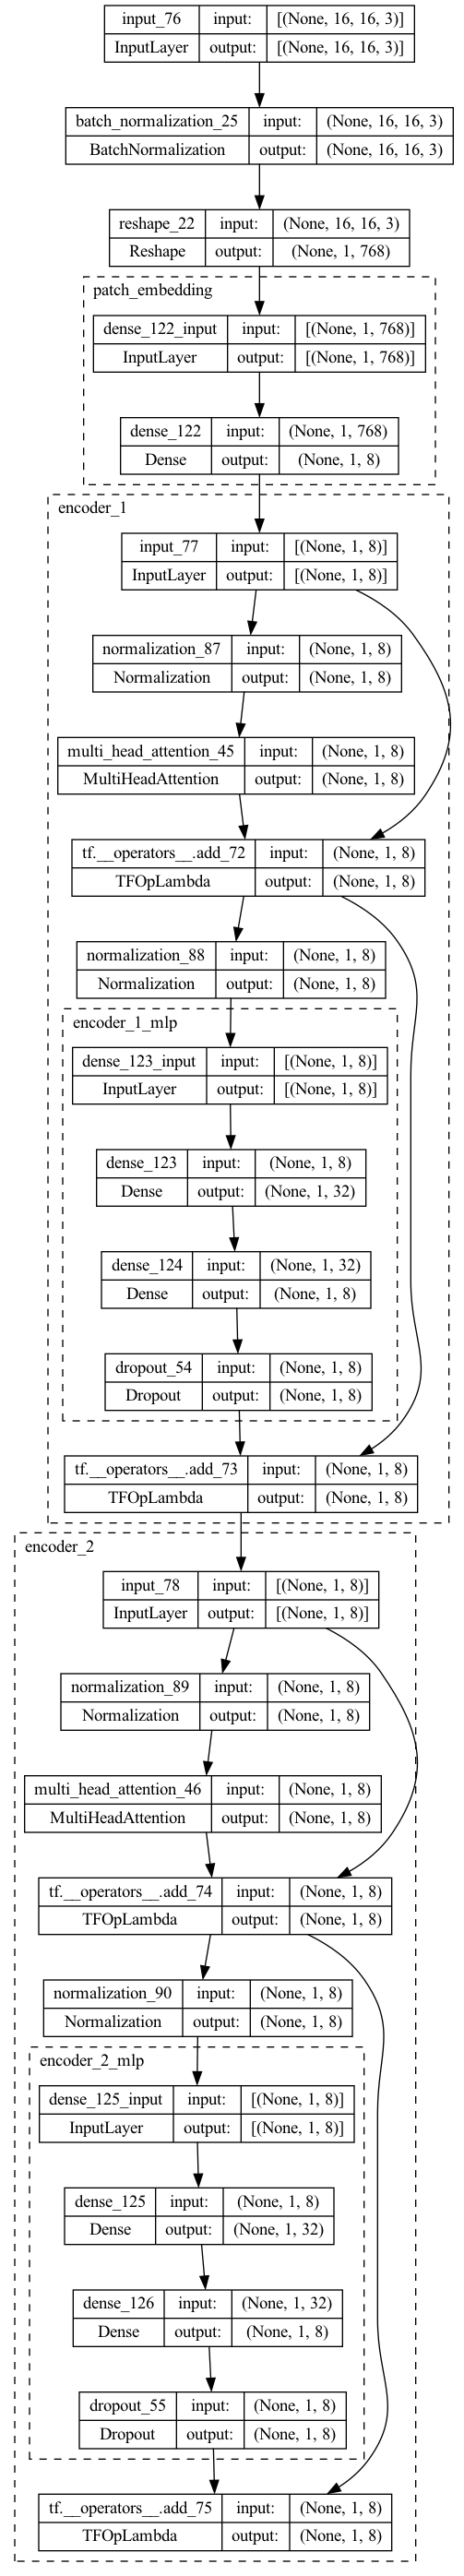

In [57]:
def create_model(encoder_units, dims, heads, dropout_rate=0.2):
    xx = tf.keras.Input((16, 16, 3))
    
    x = layers.BatchNormalization()(xx)
    x = layers.Reshape([1, -1])(x)
    x = patch_embedding_block(x, dims, name='patch_embedding')
    encoder_fn = lambda x, i: encoder_block(x, dims, heads, name='encoder_{}'.format(i + 1))
    x = reduce(encoder_fn, range(encoder_units), x)

    model = tf.keras.Model(inputs=xx, outputs=x, name='PatchTransformer')

    return model

encoder_units, dims, heads = 2, 8, 2
model = create_model(encoder_units, dims, heads)

xx = tf.keras.Input((16, 16, 3))
# output = model
output = model(xx)

print('ViT')
print('encoder_units: {}, dims: {} heads: {}'.format(
    encoder_units,
    dims,
    heads
))
print('Input: {} --> {}'.format(xx.shape, output.shape))

utils.plot_model(model, show_shapes=True, expand_nested=True)